## Perlin noise topography

In [2]:
import numpy as np
import xarray as xr
from xrspatial import perlin
import matplotlib.pyplot as plt
nx = 100
ny = 100
data = np.zeros((H, W), dtype=np.float32)
raster = xr.DataArray(data, dims=['y', 'x'])

perlin_noise = perlin(raster,freq=(nx//10,ny//10),seed=1)

NameError: name 'H' is not defined

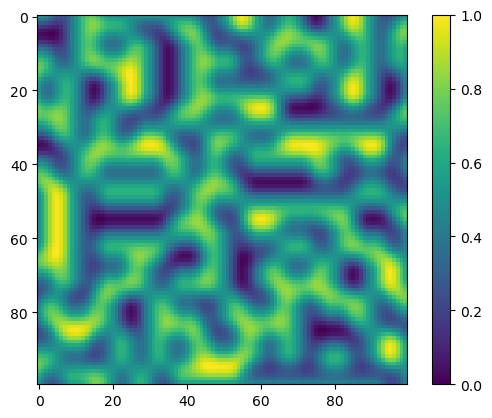

In [5]:
plt.imshow(perlin_noise)
plt.colorbar()

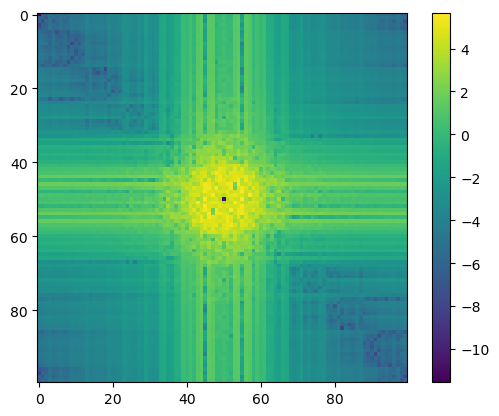

In [15]:

perlin_noise -= np.mean(perlin_noise)
freq = np.abs(calculate_2dft(perlin_noise))
plt.imshow(np.log(freq))
plt.colorbar()

## xrspatial topography

In [50]:
from xrspatial import generate_terrain, bump
# https://xarray-spatial.org/reference/_autosummary/xrspatial.bump.bump.html
# Generate Example Terrain
W = 500
H = 300

template_terrain = xr.DataArray(np.zeros((H, W)))
x_range=(-20e6, 20e6)
y_range=(-20e6, 20e6)

terrain_agg = generate_terrain(
    template_terrain, x_range=x_range, y_range=y_range
)

:Image   [x,y]   (terrain)

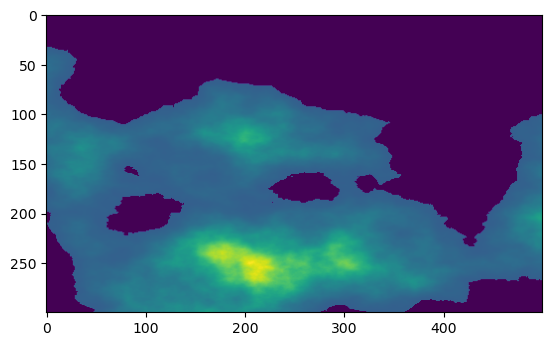

In [53]:
plt.imshow(terrain_agg.data)

## inverse fourier transform terrain generator

In [109]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_2dft(input):
    ft = np.fft.ifftshift(input)
    ft = np.fft.fft2(ft)
    return np.fft.fftshift(ft)
def calculate_2dift(input):
    ift = np.fft.ifftshift(input)
    ift = np.fft.ifft2(ift)
    ift = np.fft.fftshift(ift)
    return ift.real

nx = 512
ny = 512
dx=200
zmean = 500
max_lamda = 10e3

In [126]:
k = np.fft.fftfreq(nx,1)
m = np.fft.fftfreq(ny,1)
kk,mm = np.meshgrid(k,m)
km = kk**2+mm**2
km[0,0] = 1.
del(kk,mm)
spectrum2D = np.sqrt(np.random.uniform(0, 1, (ny,nx))) * np.exp(1.j * np.random.uniform(0, 2 * np.pi, (ny,nx)))
# spectrum2D[km<0.01] = 0.

kc = (dx/max_lamda)**2
# spectrum2D *= 1/km**1.
# spectrum2D *= (km-kc)/(1+km/kc)**2
spectrum2D *= 1/(1+km/kc/1.5)
spectrum2D[km<kc] = 0.
# spectrum2D *= km*np.exp(-km/0.05)

#axs[0].imshow(np.fft.ifftshift(np.abs(spectrum2D)),cmap='Greys')#,vmin=-0.02,vmax=0.02)
zs = np.real(np.fft.ifft2(spectrum2D))

zs = (zs/np.max(np.abs(zs))/2 + 0.5)**2

# zs = (zs/np.max(np.abs(zs))/2 + 0.5)
# zs[zs<0.] = 0.
# zs *= zmean/np.mean(zs)

spectrum2D = np.fft.fft2(zs)
spectrum2D[km<kc] = 0.
zs = np.real(np.fft.ifft2(spectrum2D))
zs -= np.min(zs)
zs *= zmean/np.mean(zs)

slope = 180/np.pi*np.arctan(np.sqrt(((zs[1:,1:]+zs[1:,:-1]-zs[:-1,1:]-zs[:-1,:-1])/2/dx)**2 + ((zs[1:,1:]+zs[:-1,1:]-zs[1:,:-1]-zs[:-1,:-1])/2/dx)**2))

print(np.mean(slope),np.max(slope),np.min(zs),np.mean(zs),np.max(zs))

19.11850129962676 59.89639250281864 0.0 1770.7300281705295


In [129]:
np.save('MO10_M200m',zs)

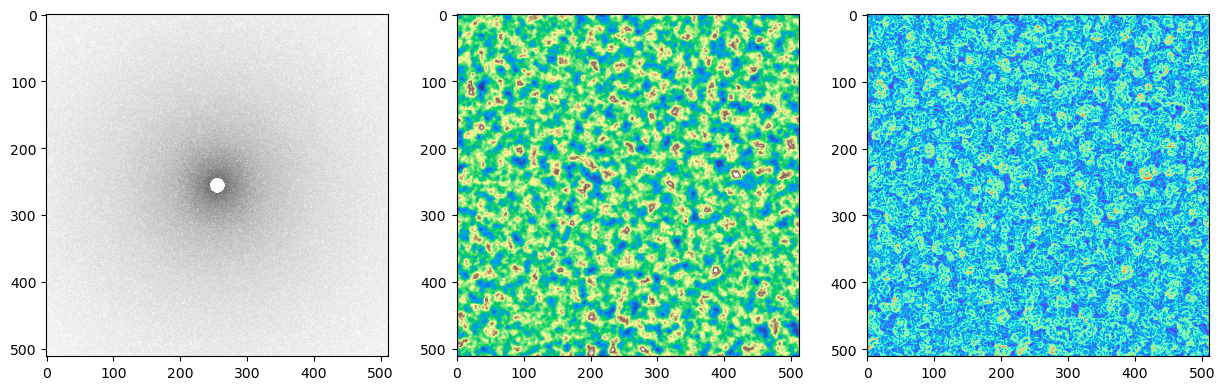

In [127]:
fig,axs = plt.subplots(ncols=3,figsize=(15,5))
axs[0].imshow(np.fft.ifftshift(np.log10(np.abs(np.fft.fft2(zs)))),cmap='Greys',vmin=3)
axs[1].imshow(zs,cmap='terrain',vmin=0.,vmax=3*zmean)
slope = 180/np.pi*np.arctan(np.sqrt(((zs[1:,1:]+zs[1:,:-1]-zs[:-1,1:]-zs[:-1,:-1])/2/dx)**2 + ((zs[1:,1:]+zs[:-1,1:]-zs[1:,:-1]-zs[:-1,:-1])/2/dx)**2))
axs[2].imshow(slope,cmap='rainbow',vmin=0.,vmax=60)


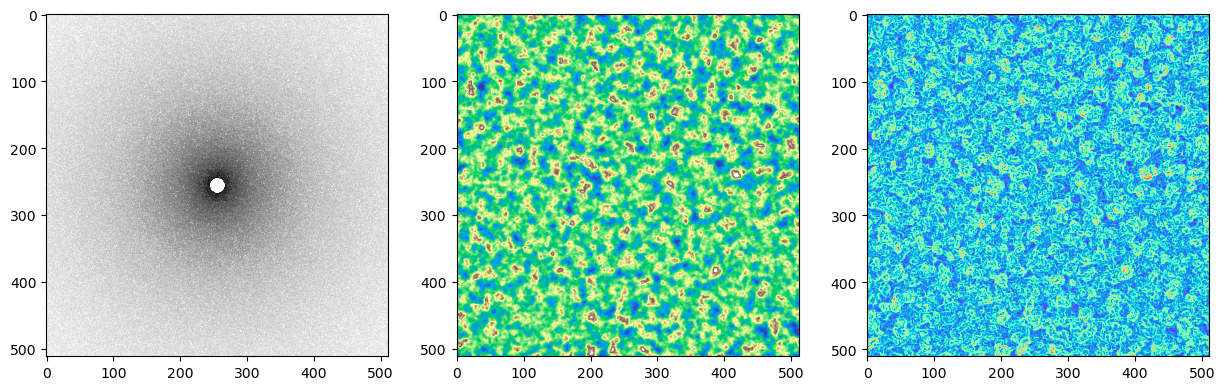

In [133]:
fig,axs = plt.subplots(ncols=3,figsize=(15,5))
axs[0].imshow(np.fft.ifftshift(np.log10(np.abs(np.fft.fft2(zs-zmean)))),cmap='Greys',vmin=3)
axs[1].imshow(zs,cmap='terrain',vmin=0.,vmax=3*zmean)
slope = 180/np.pi*np.arctan(np.sqrt(((zs[1:,1:]+zs[1:,:-1]-zs[:-1,1:]-zs[:-1,:-1])/2/dx)**2 + ((zs[1:,1:]+zs[:-1,1:]-zs[1:,:-1]-zs[:-1,:-1])/2/dx)**2))
axs[2].imshow(slope,cmap='rainbow',vmin=0.,vmax=60)

In [29]:
import matplotlib
from matplotlib.colors import LightSource
hcm = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","saddlebrown","grey","w"])
Hmax=3000
def show_H_stats(Hc,dx,extent=None,shading=False):
    fig, ax = plt.subplots(ncols=2,figsize=(10,4))
    Hcmax = np.max(Hc)
    im = ax[0].imshow(Hc, cmap=hcm,vmin=0,vmax=Hcmax, origin='lower',interpolation='none',visible=not(shading))
    if shading:
        ls = LightSource(325, 45)
        rgb = ls.shade(Hc, cmap=hcm,vmin=0,vmax=Hcmax, vert_exag=Hcmax/Hmax/dx, blend_mode='soft')
        ax[0].imshow(rgb, origin='lower',extent=extent,interpolation='bilinear')
    plt.colorbar(im,ax=ax[0],fraction=0.1, pad=0.01,orientation='vertical',extend=None)
    ax[0].set_xlabel("Lon")
    ax[0].set_ylabel("Lat")
    z_bins = np.linspace(0.,1.0001,257)*Hmax
    
    ax[1].hist(Hc.flatten(),bins=z_bins[1:],density=False, orientation="horizontal",alpha=0.5,label="Distribution")
    ax[1].set_ylim([0,Hcmax])
#     ax[1].set_yticks([])
    ax[1].set_xlabel("Number of pixel")
    ax[1].set_ylabel("Altitude")
    
    ax_cum = ax[1].twiny()
    ax_cum.hist(Hc.flatten(),bins=z_bins[:], density=True, histtype="step",color='orange', orientation="horizontal",
                cumulative=True, label="CDF")
    ax_cum.set_xlim([0,1])
    Hc_mean = np.mean(Hc)
    above_mean_ratio = np.mean(Hc>Hc_mean)
    ax[1].axhline(np.mean(Hc),color='r',linestyle='--',label='Mean')
    ax_cum.text(1/2,Hcmax*3/4,str(round(above_mean_ratio*100))+' % > mean',color='r',ha='center', va='center')
    ax_cum.set_xlabel("CDF")
    lines, labels = ax[1].get_legend_handles_labels() ; lines2, labels2 = ax_cum.get_legend_handles_labels()
    ax[1].legend(lines + lines2, labels + labels2, loc=0)
    plt.show()
    

def show_S_stats(Hc,dx,extent=None,lat=0.,Smax = 1.2,nsbins=61,deg=False):
    fig, ax = plt.subplots(ncols=2,figsize=(10,4))
    Hcmax = np.max(Hc)
    Hc_slopes = np.sqrt( ((Hc[:-1,:-1]+Hc[1:,:-1]-Hc[:-1,1:]-Hc[1:,1:])/2/dx/np.cos(np.pi*(lat)/180))**2 + ((Hc[:-1,:-1]+Hc[:-1,1:]-Hc[1:,:-1]-Hc[1:,1:])/2/dx)**2 )
    
    if deg:
        Smax = 90
        slope_bins = np.linspace(0.,90,91)
        Hc_slopes = 180/np.pi*np.arctan(Hc_slopes)
    else:
        slope_bins = np.linspace(0.,Smax,nsbins)
    z_bins = np.linspace(0.,1.0001,257)*Hmax
    
    ims = ax[0].imshow(Hc_slopes, cmap='rainbow',vmin=0,vmax=Smax,extent=extent, origin='lower',interpolation='none')
    plt.colorbar(ims,ax=ax[0],fraction=0.1, pad=0.01,orientation='vertical',extend='max')
    ax[0].set_xlabel("Lon")
    ax[0].set_ylabel("Lat")
    
    hist_field,_,_,imhs = ax[1].hist2d(Hc_slopes.flatten(),((Hc[:-1,:-1]+Hc[1:,:-1]+Hc[:-1,1:]+Hc[1:,1:])/4).flatten(),
                                       bins=(slope_bins,z_bins),density=False,cmap='magma_r',
                                       norm=matplotlib.colors.LogNorm(vmin=1,vmax=Hc_slopes.size/10) )
    plt.colorbar(imhs,ax=ax[1],fraction=0.1, pad=0.01,orientation='vertical',extend='max')
    ax[1].set_ylim([0,Hcmax])
    ax[1].set_xlim([0,Smax])
    ax[1].set_xlabel("Slope")
    if not(deg):
        ax[1].plot( np.sum(hist_field * (slope_bins[1:]/2+slope_bins[:-1]/2).reshape((len(slope_bins)-1,1)) ,axis=0 )/np.sum(hist_field,axis=0) ,(z_bins[1:]+z_bins[:-1])/2  , color='chartreuse',lw=1.5)
    plt.show()

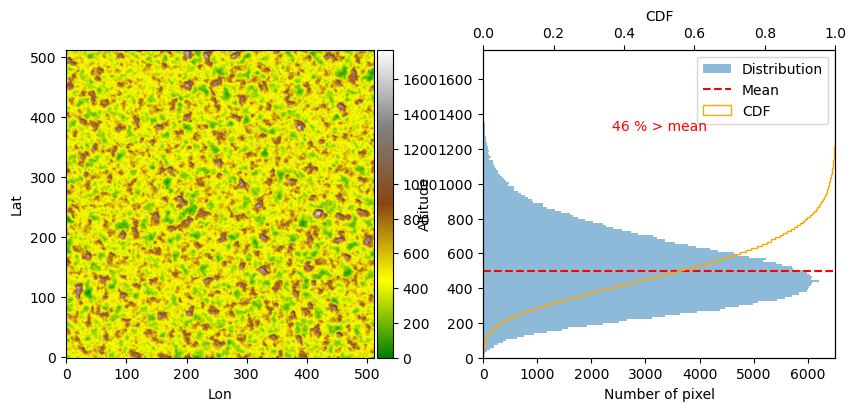

C:\Users\Nathan\AppData\Local\Temp\ipykernel_16428\2156265699.py:64: RuntimeWarning: invalid value encountered in divide
  ax[1].plot( np.sum(hist_field * (slope_bins[1:]/2+slope_bins[:-1]/2).reshape((len(slope_bins)-1,1)) ,axis=0 )/np.sum(hist_field,axis=0) ,(z_bins[1:]+z_bins[:-1])/2  , color='chartreuse',lw=1.5)


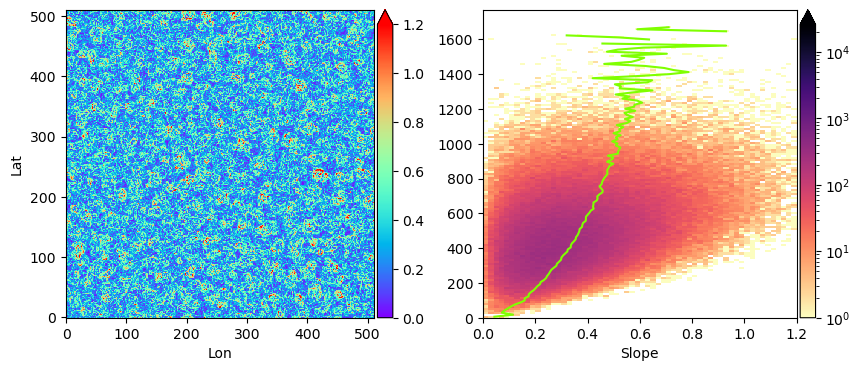

In [128]:
show_H_stats(zs,dx,shading=True)
show_S_stats(zs,dx)

In [130]:
dx/max_lamda*nx

10.24